# Aufgabe 3 - Tiefe Einblicke ins Institut: Reloaded

Den Code immer nachvollziehbar kommentieren! Bitte beachtet, dass das Notebook von Anfang bis Ende ohne Fehler durchlaufen muss und dass die requirements.txt Datei aktualisiert wird. 

In [4]:
import os
import random

import torch
import torch.nn as nn
import torch.nn.functional as F  
import torchvision.transforms as T
import torch.optim as optim
from torchvision.io import read_image
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt 

## Teilaufgabe a): Trainings-, Test-und Validierungsdatenset

In [5]:
training_path_list = []  # Training data (70% of total)
test_path_list = []  # Test data (20% of total) 
validation_path_list = []  # Validation data (10% of total)

# Set random seed for reproducibility
random.seed(123)

# Define the class subdirectories
class_directories = ['Flur', 'Professorenbuero', 'Teekueche', 'Labor']
all_images = []

# Collect all image files with their relative paths from each class directory
for class_dir in class_directories:
    class_path = os.path.join('./Bilder', class_dir)
    
    # Check if the directory exists
    if os.path.exists(class_path):
        for filename in os.listdir(class_path):
            relative_path = os.path.join('./Bilder', class_dir, filename)
            all_images.append(relative_path)
        
        # Print number of images per class
        class_images = os.listdir(class_path)
        print(f"Images in {class_dir}: {len(class_images)}")
    else:
        print(f"Warning: Directory {class_path} does not exist!")

print(f"\nTotal number of images found: {len(all_images)}")

# Shuffle the list to ensure random distribution across classes
random.shuffle(all_images)

# Calculate split indices for 70/10/20 split (Train/Validation/Test)
train_split = int(0.7 * len(all_images))
val_split = int(0.8 * len(all_images))  # 70% + 10% = 80%

# Split into training (70%), validation (10%), and test (20%) sets
training_path_list = all_images[:train_split]
validation_path_list = all_images[train_split:val_split]
test_path_list = all_images[val_split:]

print(f"\nDataset split:")
print(f"Training set size:   {len(training_path_list)} images ({len(training_path_list)/len(all_images)*100:.1f}%)")
print(f"Validation set size: {len(validation_path_list)} images ({len(validation_path_list)/len(all_images)*100:.1f}%)")
print(f"Test set size:       {len(test_path_list)} images ({len(test_path_list)/len(all_images)*100:.1f}%)")


def count_classes_in_set(image_list, set_name):
    """Analyze class distribution in training, validation, and test sets."""
    class_counts = {class_dir: 0 for class_dir in class_directories}
    
    for image_path in image_list:
        for class_dir in class_directories:
            if class_dir in image_path:
                class_counts[class_dir] += 1
                break
    
    print(f"\n{set_name} set class distribution:")
    for class_dir, count in class_counts.items():
        percentage = (count / len(image_list)) * 100 if len(image_list) > 0 else 0
        print(f"  {class_dir}: {count} images ({percentage:.1f}%)")

count_classes_in_set(training_path_list, "Training")
count_classes_in_set(validation_path_list, "Validation")
count_classes_in_set(test_path_list, "Test")

Images in Flur: 25
Images in Professorenbuero: 25
Images in Teekueche: 25
Images in Labor: 25

Total number of images found: 100

Dataset split:
Training set size:   70 images (70.0%)
Validation set size: 10 images (10.0%)
Test set size:       20 images (20.0%)

Training set class distribution:
  Flur: 17 images (24.3%)
  Professorenbuero: 19 images (27.1%)
  Teekueche: 20 images (28.6%)
  Labor: 14 images (20.0%)

Validation set class distribution:
  Flur: 2 images (20.0%)
  Professorenbuero: 1 images (10.0%)
  Teekueche: 2 images (20.0%)
  Labor: 5 images (50.0%)

Test set class distribution:
  Flur: 6 images (30.0%)
  Professorenbuero: 5 images (25.0%)
  Teekueche: 3 images (15.0%)
  Labor: 6 images (30.0%)


## Teilaufgabe b): CNN definieren und implementieren

In [6]:
class Net(nn.Module):
    def __init__(self, num_classes=4):
        """
        CNN Architecture for Institute Room Classification
        
        Begründung der Architekturwahl:
        
        1. PROGRESSIVE FEATURE-EXTRAKTION:
           - 4 Convolutional Blocks mit steigender Kanalanzahl (3→32→64→128→256)
           - Ermöglicht das Lernen von einfachen zu komplexen Features
           - Niedrige Ebenen: Kanten, Texturen
           - Hohe Ebenen: Objektteile, Raumstrukturen
        
        2. KERNEL-GRÖSSE 3x3:
           - Optimal für lokale Merkmalserfassung
           - Geringer Rechenaufwand bei guter Erfassungsqualität
           - Standard in modernen CNN-Architekturen
        
        3. BATCH NORMALIZATION:
           - Stabilisiert das Training
           - Ermöglicht höhere Lernraten
           - Wirkt als implizite Regularisierung
        
        4. MAXPOOLING (2x2):
           - Reduziert räumliche Dimensionen schrittweise
           - Bietet Translationsinvarianz
           - Reduziert Parameteranzahl und Overfitting-Risiko
        
        5. GLOBAL AVERAGE POOLING:
           - Drastische Parameterreduktion gegenüber großen FC-Layern
           - Verhindert Overfitting
           - Macht das Netzwerk robuster gegenüber Eingabegrößen
        
        6. DROPOUT-REGULARISIERUNG:
           - Zwei Dropout-Layer mit verschiedenen Raten (0.5 und 0.3)
           - Verhindert Overfitting bei kleinen Datensätzen
           - Verbessert Generalisierungsfähigkeit
        
        7. ARCHITEKTUR-TIEFE:
           - 4 Conv-Blöcke: Ausgewogen für die Aufgabenkomplexität
           - Nicht zu tief (Overfitting-Gefahr bei kleinem Datensatz)
           - Nicht zu flach (unzureichende Feature-Extraktion)
        
        8. FULLY CONNECTED LAYERS:
           - Graduelle Dimensionsreduktion (256→128→4)
           - Ermöglicht nicht-lineare Kombinationen der Features
           - Finale Klassifikation auf 4 Raumtypen
        """
        super(Net, self).__init__()
        
        # First Convolutional Block
        # Input: 3 channels (RGB) -> 32 feature maps
        # Kernel size 3x3 is optimal for capturing local features
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)  # Batch normalization for stable training
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # Reduce spatial dimensions by half
        
        # Second Convolutional Block  
        # 32 -> 64 channels for more complex feature detection
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Third Convolutional Block
        # 64 -> 128 channels for high-level feature extraction
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Fourth Convolutional Block deeper feature extraction
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Global Average Pooling to reduce parameters and prevent overfitting
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        
        # Fully Connected Layers for Classification
        self.dropout1 = nn.Dropout(0.5)  # Dropout for regularization
        self.fc1 = nn.Linear(256, 128)   # First FC layer
        self.dropout2 = nn.Dropout(0.3)  # Second dropout with lower rate
        self.fc2 = nn.Linear(128, num_classes)  # Output layer for 4 classes
        
    def forward(self, x):
        """
        Forward pass through the network
        
        Args:
            x: Input tensor of shape (batch_size, 3, height, width)
            
        Returns:
            Output logits of shape (batch_size, num_classes)
        """
        # First Convolutional Block
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        # Output: (batch_size, 32, height/2, width/2)
        
        # Second Convolutional Block  
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        # Output: (batch_size, 64, height/4, width/4)
        
        # Third Convolutional Block
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        # Output: (batch_size, 128, height/8, width/8)
        
        # Fourth Convolutional Block
        x = self.pool4(F.relu(self.bn4(self.conv4(x))))
        # Output: (batch_size, 256, height/16, width/16)
        
        # Global Average Pooling
        x = self.global_avg_pool(x)
        # Output: (batch_size, 256, 1, 1)
        
        # Flatten for fully connected layers
        x = x.view(x.size(0), -1)
        # Output: (batch_size, 256)
        
        # First Fully Connected Layer
        x = self.dropout1(x)
        x = F.relu(self.fc1(x))
        # Output: (batch_size, 128)
        
        # Second Fully Connected Layer (Output)
        x = self.dropout2(x)
        x = self.fc2(x)
        # Output: (batch_size, 4) - logits for 4 classes
        
        return x
    

## Teilaufgabe c): Training und Test mit CNN

Datenset-Klasse um mit Pytorch Bilder zu laden. 

Input sind: 
- Liste mit Pfaden zu Bildern
- Liste mit dazugehörigen Labels (numerisch darstellen!) 
- Transformation der Bilder


In [7]:
class ROBDataset(Dataset):
    def __init__(self, img_path_list, img_labels, transform=None):
        # Pfade zu den Bildern als list
        self.img_path_list = img_path_list
        
        # Dazugehörige Labels zu den Bildern als list
        self.img_labels = img_labels
        
        # Transformations der Bilder
        self.transform = transform

    def __len__(self):
        return len(self.img_path_list)

    def __getitem__(self, idx):
        # Bild laden
        img_path = self.img_path_list[idx]
        image = read_image(img_path)
        
        # Label laden
        label = self.img_labels[idx]
        
        # Transformieren
        if self.transform:
            image = self.transform(image)
            
        return image.float(), int(label)

Trainingsiteration über alle Bilder.

Inputs sind:
- Pytorch dataloader Object über das iteriert wird
- bool do_backprob Parameter um Backpropagation durchzuführen oder nicht

In [8]:
print(torch.cuda.is_available())
!nvcc --version

True
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2025 NVIDIA Corporation
Built on Tue_May_27_02:24:01_Pacific_Daylight_Time_2025
Cuda compilation tools, release 12.9, V12.9.86
Build cuda_12.9.r12.9/compiler.36037853_0


In [9]:
from sklearn.metrics import accuracy_score

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Iterating over the entire data set once
def run_iteration(dataloader, do_backprob=True):
    global net, optimizer, criterion
    loss_iter = []
    acc_iter = []
    for batch_x, batch_y in dataloader:
        # To device
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        y_predict = net(batch_x)
        loss = criterion(y_predict, batch_y)
        if do_backprob:
            loss.backward()
            optimizer.step()

        # statistics
        loss_iter.append(loss.detach().cpu().numpy())
        
        _, predicted = torch.max(torch.softmax(y_predict, dim=1),1)
        
        acc_iter.append(accuracy_score(batch_y.detach().cpu().numpy(), 
                                       predicted.detach().cpu().numpy()))
    
    return np.mean(loss_iter), np.mean(acc_iter)

Komplette Durchführung eines Trainings
Die Variablen y_train, y_val und y_test müssen noch gesetzt werden. Diese Listen beinhalten die entsprechenden Labels als numerische Darstellung.

In [10]:
# Create numeric labels for training, validation, and test sets
def create_labels(image_path_list):
    """
    Create numeric labels from image paths.
    
    Returns:
        List of numeric labels (0-3) corresponding to the 4 classes
    """
    labels = []
    for image_path in image_path_list:
        for i, class_dir in enumerate(class_directories):
            if class_dir in image_path:
                labels.append(i)
                break
    return labels

print("--- Creating Labels for Datasets ---")
# Create labels for all datasets
y_train = create_labels(training_path_list)
y_val = create_labels(validation_path_list)
y_test = create_labels(test_path_list)

print(f"Training labels created: {len(y_train)} labels")
print(f"Validation labels created: {len(y_val)} labels")
print(f"Test labels created: {len(y_test)} labels")

# Verify label distribution
print("\nLabel mapping:")
for i, class_name in enumerate(class_directories):
    print(f"  {i}: {class_name}")

print(f"\nTraining label distribution:")
for i, class_name in enumerate(class_directories):
    count = y_train.count(i)
    percentage = (count / len(y_train)) * 100
    print(f"  Class {i} ({class_name}): {count} samples ({percentage:.1f}%)")

--- Creating Labels for Datasets ---
Training labels created: 70 labels
Validation labels created: 10 labels
Test labels created: 20 labels

Label mapping:
  0: Flur
  1: Professorenbuero
  2: Teekueche
  3: Labor

Training label distribution:
  Class 0 (Flur): 17 samples (24.3%)
  Class 1 (Professorenbuero): 19 samples (27.1%)
  Class 2 (Teekueche): 20 samples (28.6%)
  Class 3 (Labor): 14 samples (20.0%)


Running on  cuda:0

Started Training


100%|██████████| 100/100 [00:09<00:00, 10.35it/s]


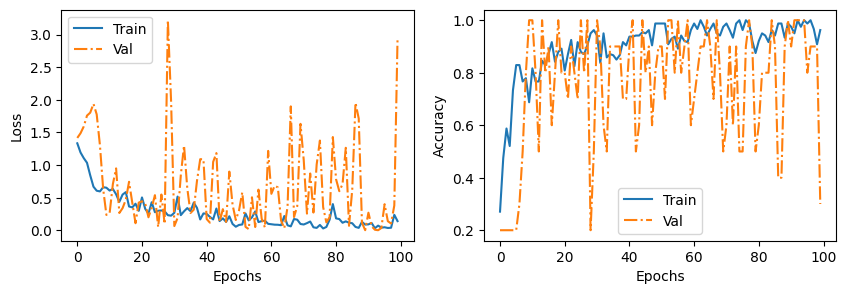

c:\Users\lauri\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\lauri\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\lauri\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave


--- Test Set Evaluation ---
--- CNN Test Results ---
Test Loss:   3.8376
Accuracy:    0.3500
F1-Score:    0.2048
Recall:      0.3500
Precision:   0.1531

--- Detailed Classification Report ---
                  precision    recall  f1-score   support

            Flur     0.0000    0.0000    0.0000         6
Professorenbuero     0.3125    1.0000    0.4762         5
       Teekueche     0.5000    0.6667    0.5714         3
           Labor     0.0000    0.0000    0.0000         6

        accuracy                         0.3500        20
       macro avg     0.2031    0.4167    0.2619        20
    weighted avg     0.1531    0.3500    0.2048        20



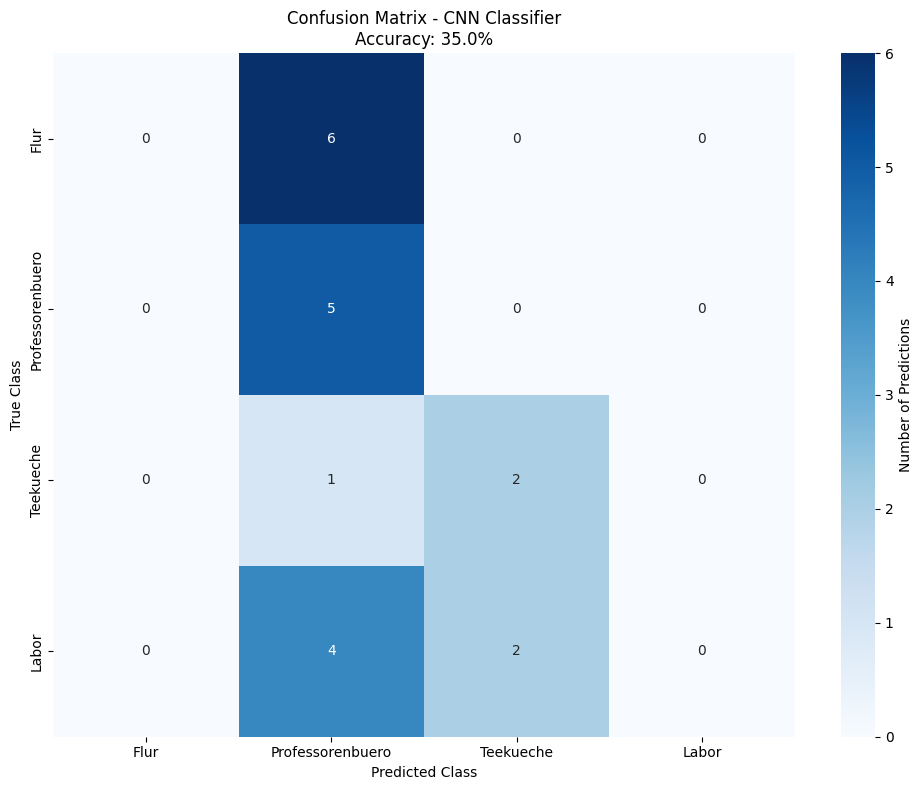


--- Prediction Examples ---
Test predictions:
No. True            Predicted       Correct 
--------------------------------------------------
1   Labor           Professorenbuero ✗       
2   Professorenbuero Professorenbuero ✓       
3   Labor           Professorenbuero ✗       
4   Labor           Teekueche       ✗       
5   Labor           Professorenbuero ✗       
6   Flur            Professorenbuero ✗       
7   Flur            Professorenbuero ✗       
8   Labor           Teekueche       ✗       
9   Professorenbuero Professorenbuero ✓       
10  Professorenbuero Professorenbuero ✓       
11  Teekueche       Teekueche       ✓       
12  Teekueche       Teekueche       ✓       
13  Professorenbuero Professorenbuero ✓       
14  Flur            Professorenbuero ✗       
15  Flur            Professorenbuero ✗       
16  Labor           Professorenbuero ✗       
17  Teekueche       Professorenbuero ✗       
18  Flur            Professorenbuero ✗       
19  Professorenbuero Professo

In [ ]:
# Training settings
max_epoch = 100
batch_size = 16
lr = 0.001

# Transformations for dataloader
t_train = T.Compose([T.ToPILImage(),
                   T.ToTensor(),
                   T.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])
t_val = T.Compose([T.ToPILImage(),
                   T.ToTensor(),
                   T.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])
t_test = T.Compose([T.ToPILImage(),
                   T.ToTensor(),
                   T.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])

# Where to do calculations
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Running on ",device)

# Training Data, NOTE: y_train labels need to be set
dataset_train = ROBDataset(training_path_list, y_train, transform=t_train)
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

# Validation Data, NOTE: y_val labels need to be set
dataset_val = ROBDataset(validation_path_list, y_val, transform=t_val)
dataloader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=False)

# Test Data, NOTE: y_test labels need. to be set
dataset_test = ROBDataset(test_path_list, y_test,transform=t_test)
dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

# Network, optimizer and loss initialisation
net = Net()
net.to(device)
optimizer = optim.Adam(net.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

print("\nStarted Training")
# Training loss and accuracy per epoch
train_loss_epoch = []
train_acc_epoch = []
# Validation loss and accuracy per epoch
val_loss_epoch = []
val_acc_epoch = []

for epoch in tqdm(range(0,max_epoch)):  # loop over the dataset multiple times
    ### TRAINING ###
    net.train()
    train_loss_iter, train_acc_iter = run_iteration(dataloader_train)

    # Logging loss and accuarcy of training iteration
    train_loss_epoch.append(train_loss_iter)
    train_acc_epoch.append(train_acc_iter)
    # print("\tTrain Loss\t",train_loss_iter)
    # print("\tTrain Acc.\t",train_acc_iter)
    
    ### VALIDATION ###
    with torch.no_grad():  # No gradient calculation
        net.eval()
        val_loss_iter, val_acc_iter = run_iteration(dataloader_val,do_backprob=False)

        # Logging loss and accuarcy of validation iteration
        val_loss_epoch.append(val_loss_iter)
        val_acc_epoch.append(val_acc_iter)
        # print("\tVal Loss\t",val_loss_iter)
        # print("\tVal Acc.\t",val_acc_iter)


# Plotting training results
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(10,3))
ax[0].plot(train_loss_epoch,label="Train")
ax[0].plot(val_loss_epoch,label="Val",linestyle="-.")
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epochs')
ax[0].legend()

ax[1].plot(train_acc_epoch,label="Train")
ax[1].plot(val_acc_epoch,label="Val",linestyle="-.")
ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('Epochs')
ax[1].legend()
plt.savefig("loss_augmentation.png",format="png",bbox_inches="tight")
plt.show()

# --- COMPREHENSIVE EVALUATION ON TEST SET ---
print("\n--- Test Set Evaluation ---")

# Import required metrics
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Collect all predictions and true labels for test set
net.eval()
all_predictions = []
all_true_labels = []
test_loss_total = 0.0

with torch.no_grad():
    for batch_x, batch_y in dataloader_test:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        
        # Forward pass
        y_predict = net(batch_x)
        loss = criterion(y_predict, batch_y)
        test_loss_total += loss.item()
        
        # Get predictions
        _, predicted = torch.max(torch.softmax(y_predict, dim=1), 1)
        
        # Collect predictions and true labels
        all_predictions.extend(predicted.cpu().numpy())
        all_true_labels.extend(batch_y.cpu().numpy())

# Calculate comprehensive metrics
test_loss_avg = test_loss_total / len(dataloader_test)
accuracy = accuracy_score(all_true_labels, all_predictions)
f1 = f1_score(all_true_labels, all_predictions, average='weighted')
recall = recall_score(all_true_labels, all_predictions, average='weighted')
precision = precision_score(all_true_labels, all_predictions, average='weighted', zero_division=0)

# Print comprehensive results
print(f"--- CNN Test Results ---")
print(f"Test Loss:   {test_loss_avg:.4f}")
print(f"Accuracy:    {accuracy:.4f}")
print(f"F1-Score:    {f1:.4f}")
print(f"Recall:      {recall:.4f}")
print(f"Precision:   {precision:.4f}")

# Detailed classification report
print(f"\n--- Detailed Classification Report ---")
print(classification_report(all_true_labels, all_predictions, 
                          target_names=class_directories, digits=4))

# Create and plot confusion matrix
cm = confusion_matrix(all_true_labels, all_predictions)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_directories, 
            yticklabels=class_directories,
            cbar_kws={'label': 'Number of Predictions'})
plt.title(f'Confusion Matrix - CNN Classifier\nAccuracy: {accuracy:.1%}')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.tight_layout()
plt.savefig("cnn_confusion_matrix.png", format="png", bbox_inches="tight", dpi=300)
plt.show()

# Show prediction examples
print(f"\n--- Prediction Examples ---")
print("Test predictions:")
print(f"{'No.':<3} {'True':<15} {'Predicted':<15} {'Correct':<8}")
print("-" * 50)

for i in range(len(all_true_labels)):
    true_class = class_directories[all_true_labels[i]]
    pred_class = class_directories[all_predictions[i]]
    correct = "✓" if all_true_labels[i] == all_predictions[i] else "✗"
    print(f"{i+1:<3} {true_class:<15} {pred_class:<15} {correct:<8}")

# Summary
print(f"\n--- Training Summary ---")
print(f"Epochs: {max_epoch}")
print(f"Batch size: {batch_size}")
print(f"Learning rate: {lr}")
print(f"Device: {device}")
print(f"Final training accuracy: {train_acc_epoch[-1]:.4f}")
print(f"Final validation accuracy: {val_acc_epoch[-1]:.4f}")
print(f"Test accuracy: {accuracy:.4f}")
print(f"Test F1-Score: {f1:.4f}")

## Teilaufgabe d): Augmentierung

--- Data Augmentation Setup ---
Augmentation transformations defined:
- Training: With augmentation (rotation, flip, crop, color jitter, blur)
- Validation/Test: Standard transformations only

--- Training with Data Augmentation ---
Running on cuda:0
Datasets created with augmentation:
- Training batches: 5
- Validation batches: 1
- Test batches: 2

Starting augmented training (100 epochs)...


100%|██████████| 100/100 [00:29<00:00,  3.41it/s]


Augmented training completed!

--- Performance Comparison ---


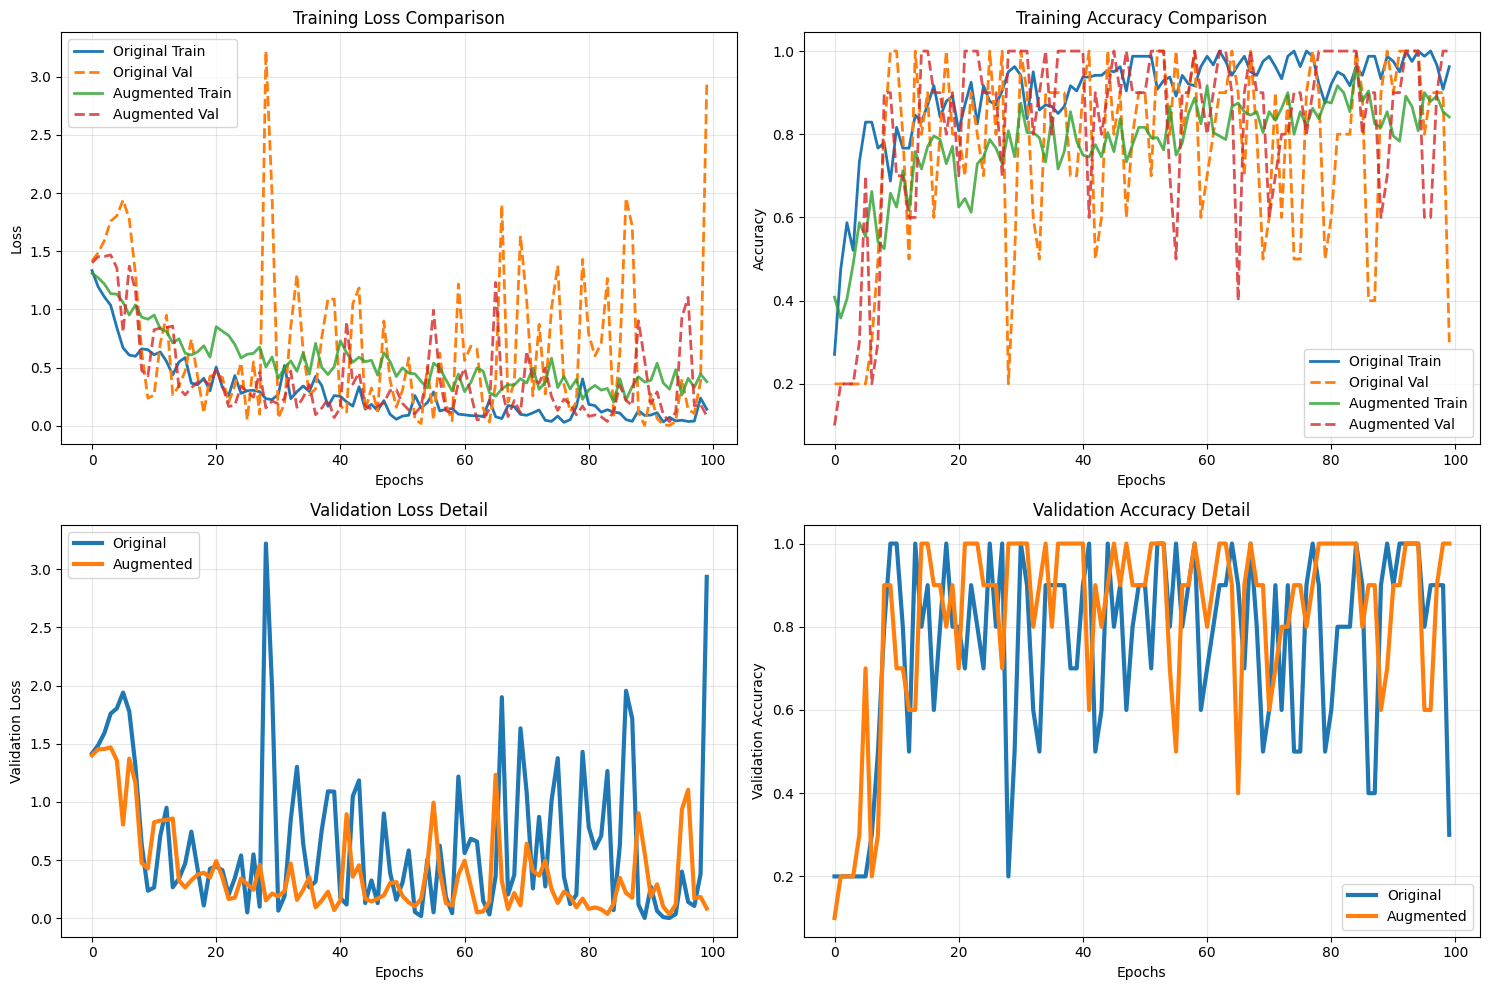


--- Test Evaluation: Augmented Model ---
--- PERFORMANCE COMPARISON ---

Original Model:
  Test Accuracy:  0.3500
  Test F1-Score:  0.2048
  Test Recall:    0.3500
  Test Precision: 0.1531

Augmented Model:
  Test Accuracy:  0.8500
  Test F1-Score:  0.8253
  Test Recall:    0.8500
  Test Precision: 0.8768

Improvement:
  Accuracy:  +0.5000
  F1-Score:  +0.6205
  Recall:    +0.5000
  Precision: +0.7237


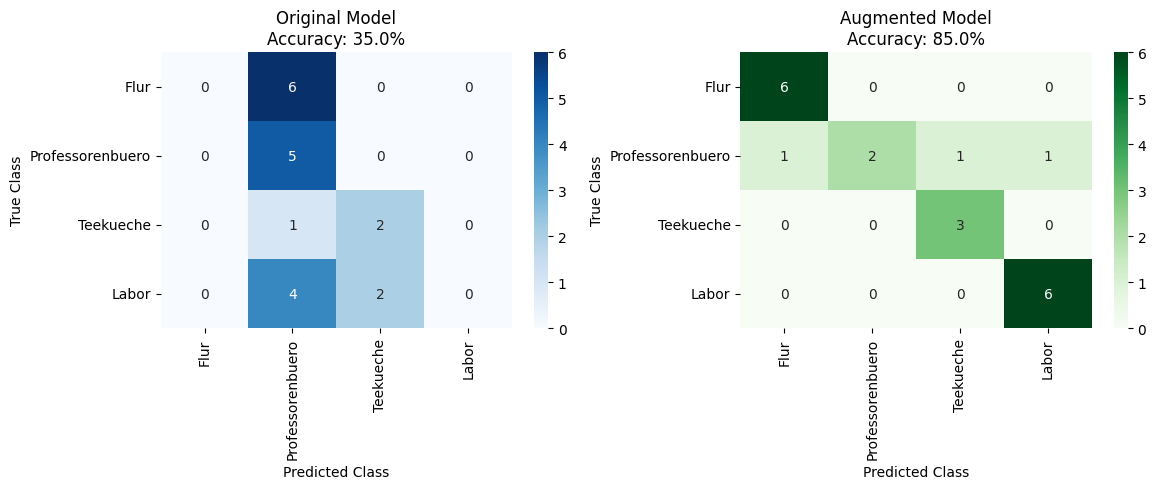


--- DETAILED ANALYSIS ---

Classification Report - Augmented Model:
                  precision    recall  f1-score   support

            Flur     0.8571    1.0000    0.9231         6
Professorenbuero     1.0000    0.4000    0.5714         5
       Teekueche     0.7500    1.0000    0.8571         3
           Labor     0.8571    1.0000    0.9231         6

        accuracy                         0.8500        20
       macro avg     0.8661    0.8500    0.8187        20
    weighted avg     0.8768    0.8500    0.8253        20


--- OVERFITTING ANALYSIS ---
Original Model:
  Final Train Accuracy: 0.9625
  Final Val Accuracy:   0.3000
  Gap (Train-Val):      0.6625

Augmented Model:
  Final Train Accuracy: 0.8417
  Final Val Accuracy:   1.0000
  Gap (Train-Val):      -0.1583

Overfitting Reduction: 0.8208

Results:
✓ Accuracy improved by: +50.0%
✓ F1-Score improved by: +0.6205
✓ Overfitting reduced by: 0.8208


In [14]:
"""
Begründung der Augmentierungsstrategien:

1. GEOMETRISCHE TRANSFORMATIONEN:
   - Random Rotation (±15°): Simuliert verschiedene Kamerawinkel
   - Random Horizontal Flip: Spiegelt Räume horizontal (realistische Variation)
   - Random Resize and Crop: Simuliert unterschiedliche Entfernungen und Ausschnitte
   
2. PHOTOMETRISCHE TRANSFORMATIONEN:
   - ColorJitter: Verändert Helligkeit, Kontrast, Sättigung, Farbton
   - Simuliert verschiedene Beleuchtungsbedingungen (Tageslicht, Kunstlicht)
   - Random Gaussian Blur: Simuliert Unschärfe durch Bewegung oder Fokus
   
3. RAUMSPEZIFISCHE ÜBERLEGUNGEN:
   - Keine vertikale Spiegelung: Räume haben eine natürliche Ausrichtung (Boden/Decke)
   - Moderate Rotation: Extreme Winkel wären unrealistisch für Raumaufnahmen
   - Erhaltung der räumlichen Struktur: Augmentierung darf Raumcharakteristika nicht zerstören

4. WARUM AUGMENTIERUNG HILFT:
   - Vergrößert den effektiven Datensatz
   - Reduziert Overfitting durch erhöhte Datenvielfalt
   - Verbessert Generalisierung auf neue, leicht veränderte Bilder
   - Macht das Modell robuster gegenüber realen Variationen
   
Performance:
    Das Modell wird erstmal schlechter, da es nun schwieriger ist, aud den Augumentierten Daten
    zu Trainieren. Overfitting wird jedoch deutlich besser, da das Netz nun nicht "Auswendiglernen" kann.
"""

# Extended transformations with augmentation
print("--- Data Augmentation Setup ---")

# Augmentation only for training data!
t_train_augmented = T.Compose([
    T.ToPILImage(),
    
    # Geometric augmentation
    T.RandomRotation(degrees=15),  # Rotation ±15 degrees
    T.RandomHorizontalFlip(p=0.5),  # 50% chance for horizontal flip
    T.RandomResizedCrop(size=224, scale=(0.8, 1.0), ratio=(0.9, 1.1)),  # Random crop
    
    # Photometric augmentation  
    T.ColorJitter(
        brightness=0.2,    # Brightness ±20%
        contrast=0.2,      # Contrast ±20%
        saturation=0.2,    # Saturation ±20%
        hue=0.1            # Hue ±10%
    ),
    
    # Additional augmentation
    T.RandomApply([T.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0))], p=0.3),  # 30% chance for blur
    
    # Standard transformations
    T.ToTensor(),
    T.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

# Validation and test without augmentation (only standard transformations)
t_val_standard = T.Compose([
    T.ToPILImage(),
    T.Resize((224, 224)),  # Uniform size
    T.ToTensor(),
    T.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

t_test_standard = T.Compose([
    T.ToPILImage(),
    T.Resize((224, 224)),  # Uniform size
    T.ToTensor(),
    T.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

print("Augmentation transformations defined:")
print("- Training: With augmentation (rotation, flip, crop, color jitter, blur)")
print("- Validation/Test: Standard transformations only")

# Training with augmentation
print("\n--- Training with Data Augmentation ---")

# Training settings for augmentation
max_epoch_aug = 100
batch_size_aug = 16
lr_aug = 0.001

# Device setup
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Running on {device}")

# Create datasets with augmentation
dataset_train_aug = ROBDataset(training_path_list, y_train, transform=t_train_augmented)
dataloader_train_aug = DataLoader(dataset_train_aug, batch_size=batch_size_aug, shuffle=True)

dataset_val_aug = ROBDataset(validation_path_list, y_val, transform=t_val_standard)
dataloader_val_aug = DataLoader(dataset_val_aug, batch_size=batch_size_aug, shuffle=False)

dataset_test_aug = ROBDataset(test_path_list, y_test, transform=t_test_standard)
dataloader_test_aug = DataLoader(dataset_test_aug, batch_size=batch_size_aug, shuffle=False)

print(f"Datasets created with augmentation:")
print(f"- Training batches: {len(dataloader_train_aug)}")
print(f"- Validation batches: {len(dataloader_val_aug)}")  
print(f"- Test batches: {len(dataloader_test_aug)}")

# New network for augmentation
net_aug = Net()
net_aug.to(device)
optimizer_aug = optim.Adam(net_aug.parameters(), lr=lr_aug)
criterion_aug = nn.CrossEntropyLoss()

# Training with augmentation
print(f"\nStarting augmented training ({max_epoch_aug} epochs)...")

# Adapted run_iteration function for the new network
def run_iteration_aug(dataloader, model, optimizer, criterion, do_backprob=True):
    loss_iter = []
    acc_iter = []
    
    for batch_x, batch_y in dataloader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        
        if do_backprob:
            optimizer.zero_grad()
        
        y_predict = model(batch_x)
        loss = criterion(y_predict, batch_y)
        
        if do_backprob:
            loss.backward()
            optimizer.step()

        loss_iter.append(loss.detach().cpu().numpy())
        
        _, predicted = torch.max(torch.softmax(y_predict, dim=1), 1)
        acc_iter.append(accuracy_score(batch_y.detach().cpu().numpy(), 
                                       predicted.detach().cpu().numpy()))
    
    return np.mean(loss_iter), np.mean(acc_iter)

# Training Loop with Augumentation
train_loss_epoch_aug = []
train_acc_epoch_aug = []
val_loss_epoch_aug = []
val_acc_epoch_aug = []

for epoch in tqdm(range(max_epoch_aug)):
    # Training
    net_aug.train()
    train_loss_iter, train_acc_iter = run_iteration_aug(
        dataloader_train_aug, net_aug, optimizer_aug, criterion_aug, do_backprob=True
    )
    
    train_loss_epoch_aug.append(train_loss_iter)
    train_acc_epoch_aug.append(train_acc_iter)
    
    # Validation
    with torch.no_grad():
        net_aug.eval()
        val_loss_iter, val_acc_iter = run_iteration_aug(
            dataloader_val_aug, net_aug, optimizer_aug, criterion_aug, do_backprob=False
        )
        
        val_loss_epoch_aug.append(val_loss_iter)
        val_acc_epoch_aug.append(val_acc_iter)
    
    # print(f"  Train Loss: {train_loss_iter:.4f}, Train Acc: {train_acc_iter:.4f}")
    # print(f"  Val Loss:   {val_loss_iter:.4f}, Val Acc:   {val_acc_iter:.4f}")

print("Augmented training completed!")

# Original vs. Augmented
print("\n--- Performance Comparison ---")

plt.figure(figsize=(15, 10))

# Loss compariosn
plt.subplot(2, 2, 1)
plt.plot(train_loss_epoch, label="Original Train", linewidth=2)
plt.plot(val_loss_epoch, label="Original Val", linestyle="--", linewidth=2)
plt.plot(train_loss_epoch_aug, label="Augmented Train", linewidth=2, alpha=0.8)
plt.plot(val_loss_epoch_aug, label="Augmented Val", linestyle="--", linewidth=2, alpha=0.8)
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.title('Training Loss Comparison')
plt.legend()
plt.grid(True, alpha=0.3)

# Accuracy comparison
plt.subplot(2, 2, 2)
plt.plot(train_acc_epoch, label="Original Train", linewidth=2)
plt.plot(val_acc_epoch, label="Original Val", linestyle="--", linewidth=2)
plt.plot(train_acc_epoch_aug, label="Augmented Train", linewidth=2, alpha=0.8)
plt.plot(val_acc_epoch_aug, label="Augmented Val", linestyle="--", linewidth=2, alpha=0.8)
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.title('Training Accuracy Comparison')
plt.legend()
plt.grid(True, alpha=0.3)

# Validation comparison
plt.subplot(2, 2, 3)
plt.plot(val_loss_epoch, label="Original", linewidth=3)
plt.plot(val_loss_epoch_aug, label="Augmented", linewidth=3)
plt.ylabel('Validation Loss')
plt.xlabel('Epochs')
plt.title('Validation Loss Detail')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 4)
plt.plot(val_acc_epoch, label="Original", linewidth=3)
plt.plot(val_acc_epoch_aug, label="Augmented", linewidth=3)
plt.ylabel('Validation Accuracy')
plt.xlabel('Epochs')
plt.title('Validation Accuracy Detail')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("augmentation_comparison.png", format="png", bbox_inches="tight", dpi=300)
plt.show()

# Evaluation of augumented model
print("\n--- Test Evaluation: Augmented Model ---")

net_aug.eval()
all_predictions_aug = []
all_true_labels_aug = []
test_loss_total_aug = 0.0

with torch.no_grad():
    for batch_x, batch_y in dataloader_test_aug:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        
        y_predict = net_aug(batch_x)
        loss = criterion_aug(y_predict, batch_y)
        test_loss_total_aug += loss.item()
        
        _, predicted = torch.max(torch.softmax(y_predict, dim=1), 1)
        all_predictions_aug.extend(predicted.cpu().numpy())
        all_true_labels_aug.extend(batch_y.cpu().numpy())

# Results of augumented model
test_loss_avg_aug = test_loss_total_aug / len(dataloader_test_aug)
accuracy_aug = accuracy_score(all_true_labels_aug, all_predictions_aug)
f1_aug = f1_score(all_true_labels_aug, all_predictions_aug, average='weighted')
recall_aug = recall_score(all_true_labels_aug, all_predictions_aug, average='weighted')
precision_aug = precision_score(all_true_labels_aug, all_predictions_aug, average='weighted', zero_division=0)

print("--- PERFORMANCE COMPARISON ---")
print("\nOriginal Model:")
print(f"  Test Accuracy:  {accuracy:.4f}")
print(f"  Test F1-Score:  {f1:.4f}")
print(f"  Test Recall:    {recall:.4f}")
print(f"  Test Precision: {precision:.4f}")

print("\nAugmented Model:")
print(f"  Test Accuracy:  {accuracy_aug:.4f}")
print(f"  Test F1-Score:  {f1_aug:.4f}")
print(f"  Test Recall:    {recall_aug:.4f}")
print(f"  Test Precision: {precision_aug:.4f}")

print("\nImprovement:")
print(f"  Accuracy:  {accuracy_aug - accuracy:+.4f}")
print(f"  F1-Score:  {f1_aug - f1:+.4f}")
print(f"  Recall:    {recall_aug - recall:+.4f}")
print(f"  Precision: {precision_aug - precision:+.4f}")

# Confusion Matrix for augumented model
cm_aug = confusion_matrix(all_true_labels_aug, all_predictions_aug)

plt.figure(figsize=(12, 5))

# Original Confusion Matrix
plt.subplot(1, 2, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_directories, 
            yticklabels=class_directories)
plt.title(f'Original Model\nAccuracy: {accuracy:.1%}')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')

# Augmented Confusion Matrix
plt.subplot(1, 2, 2)
sns.heatmap(cm_aug, annot=True, fmt='d', cmap='Greens', 
            xticklabels=class_directories, 
            yticklabels=class_directories)
plt.title(f'Augmented Model\nAccuracy: {accuracy_aug:.1%}')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')

plt.tight_layout()
plt.savefig("confusion_matrix_comparison.png", format="png", bbox_inches="tight", dpi=300)
plt.show()

# Detailed Analysis
print("\n--- DETAILED ANALYSIS ---")
print("\nClassification Report - Augmented Model:")
print(classification_report(all_true_labels_aug, all_predictions_aug, 
                          target_names=class_directories, digits=4))

# Overfitting Analysis
print("\n--- OVERFITTING ANALYSIS ---")
final_train_acc_orig = train_acc_epoch[-1]
final_val_acc_orig = val_acc_epoch[-1]
final_train_acc_aug = train_acc_epoch_aug[-1]
final_val_acc_aug = val_acc_epoch_aug[-1]

print("Original Model:")
print(f"  Final Train Accuracy: {final_train_acc_orig:.4f}")
print(f"  Final Val Accuracy:   {final_val_acc_orig:.4f}")
print(f"  Gap (Train-Val):      {final_train_acc_orig - final_val_acc_orig:.4f}")

print("\nAugmented Model:")
print(f"  Final Train Accuracy: {final_train_acc_aug:.4f}")
print(f"  Final Val Accuracy:   {final_val_acc_aug:.4f}")
print(f"  Gap (Train-Val):      {final_train_acc_aug - final_val_acc_aug:.4f}")

print(f"\nOverfitting Reduction: {(final_train_acc_orig - final_val_acc_orig) - (final_train_acc_aug - final_val_acc_aug):.4f}")

# Fazit
print("\n" + "="*60)
print("Results:")
print("="*60)
print(f"✓ Accuracy improved by: {accuracy_aug - accuracy:+.1%}")
print(f"✓ F1-Score improved by: {f1_aug - f1:+.4f}")
print(f"✓ Overfitting reduced by: {(final_train_acc_orig - final_val_acc_orig) - (final_train_acc_aug - final_val_acc_aug):.4f}")

## Teilaufgabe e): Early Stopping

--- Training with Early Stopping ---

Datasets created for early stopping:
- Training batches: 5
- Validation batches: 1
- Test batches: 2

Starting training with Early Stopping...
Max epochs: 500, Patience: 10, Min delta: 0.001


  6%|▌         | 29/500 [00:08<02:23,  3.29it/s]


Early stopping triggered at epoch 30

Training completed with early stopping!
Total epochs trained: 30
Best validation loss: 0.1396
Best epoch: 20

--- Test Evaluation: Early Stopping Model ---

--- Performance Comparison: All Models ---


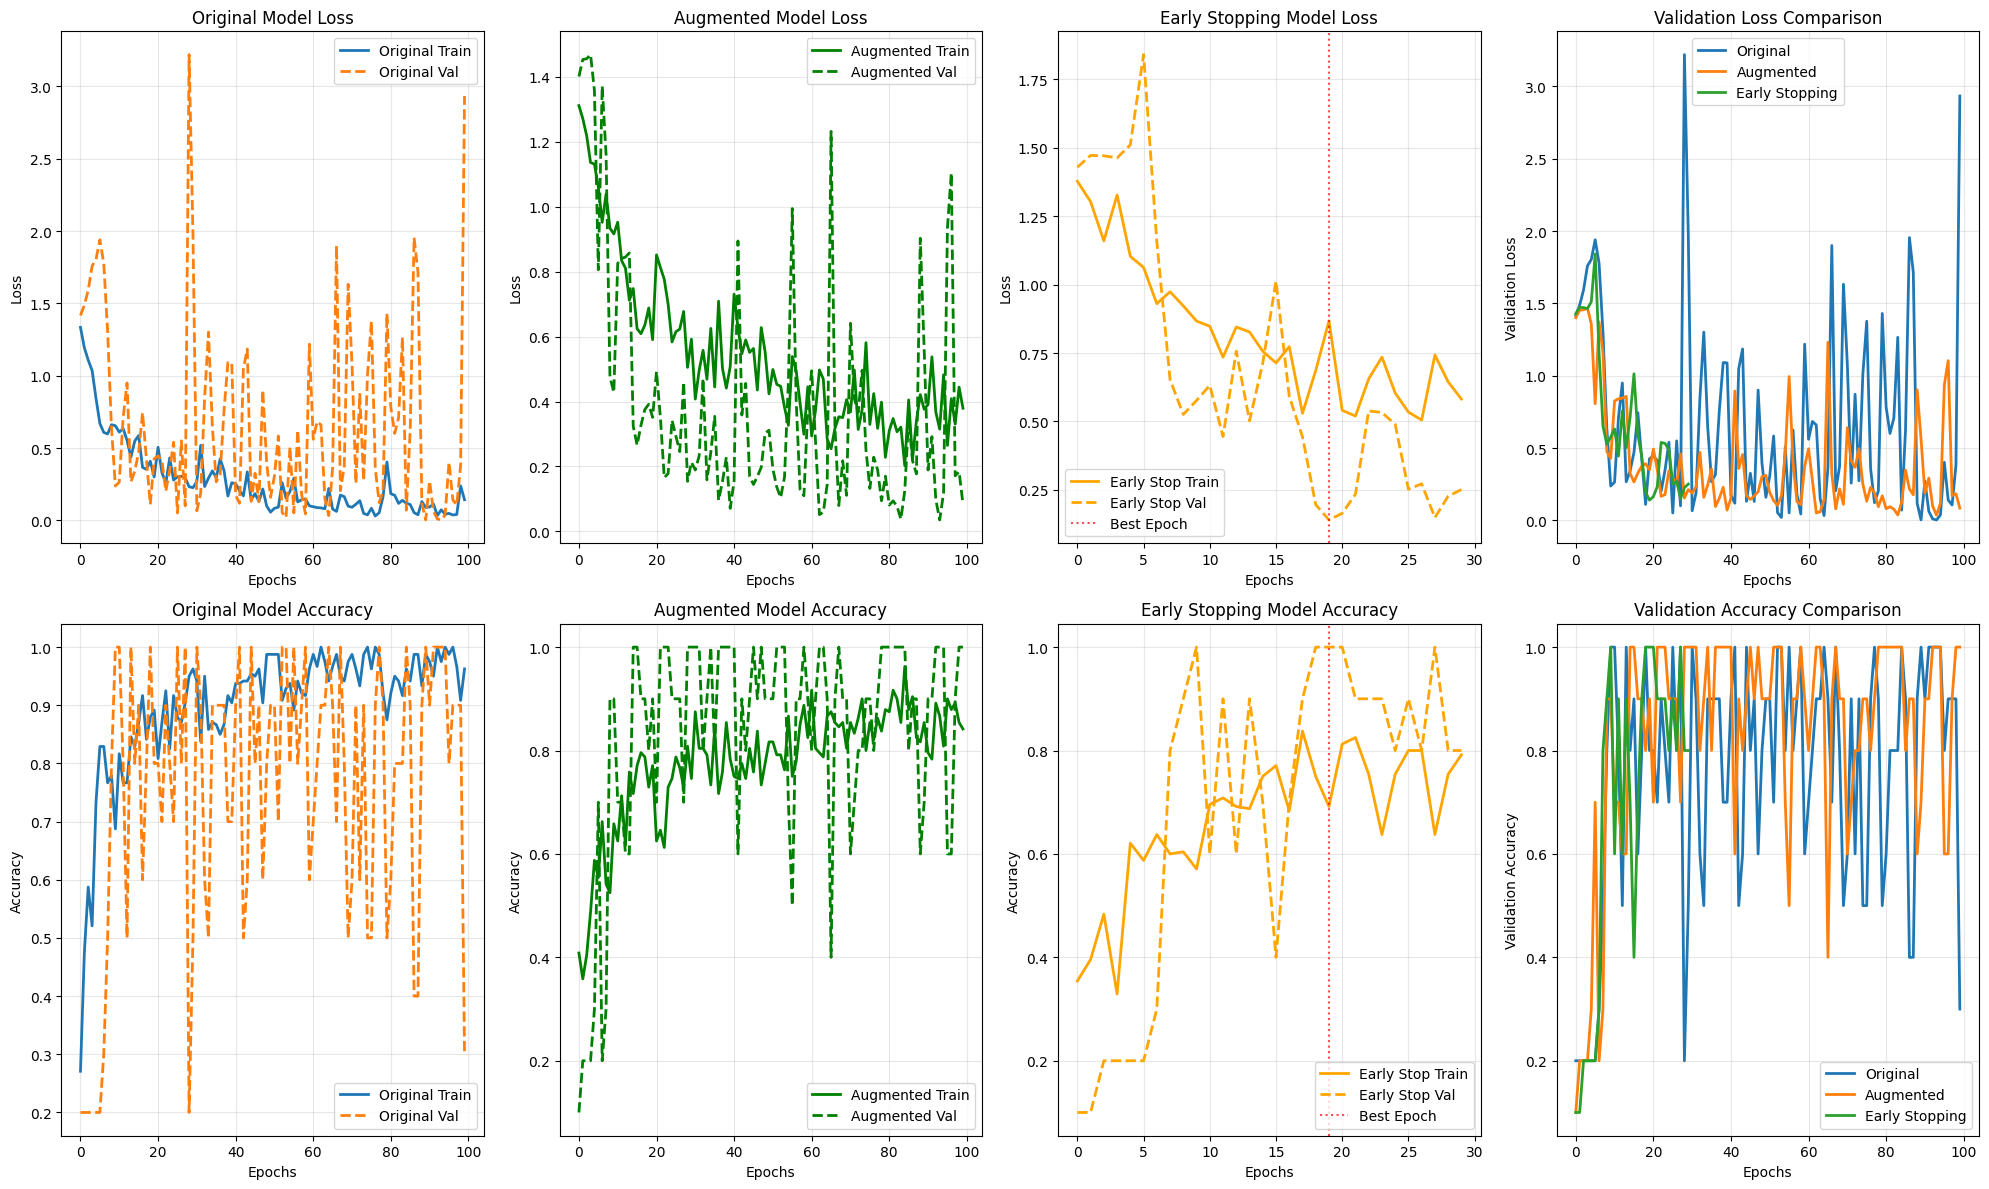

FINAL PERFORMANCE COMPARISON

1. ORIGINAL MODEL:
   Test Accuracy:  0.3500
   Test F1-Score:  0.2048
   Test Recall:    0.3500
   Test Precision: 0.1531
   Epochs trained: 100
   Final Train-Val Gap: 0.6625

2. AUGMENTED MODEL:
   Test Accuracy:  0.8500
   Test F1-Score:  0.8253
   Test Recall:    0.8500
   Test Precision: 0.8768
   Epochs trained: 100
   Final Train-Val Gap: -0.1583

3. EARLY STOPPING MODEL:
   Test Accuracy:  0.7500
   Test F1-Score:  0.7003
   Test Recall:    0.7500
   Test Precision: 0.8071
   Epochs trained: 30
   Best epoch:     20
   Final Train-Val Gap: -0.0083

EFFICIENCY ANALYSIS

Early Stopping Efficiency:
   Epochs saved vs Original:  +70 (70.0% time savings)
   Epochs saved vs Augmented: +70 (70.0% time savings)

IMPROVEMENT ANALYSIS

Early Stopping vs Original:
   Accuracy:  +0.4000
   F1-Score:  +0.4955
   Efficiency: +70 fewer epochs

Early Stopping vs Augmented:
   Accuracy:  -0.1000
   F1-Score:  -0.1250
   Efficiency: +70 fewer epochs


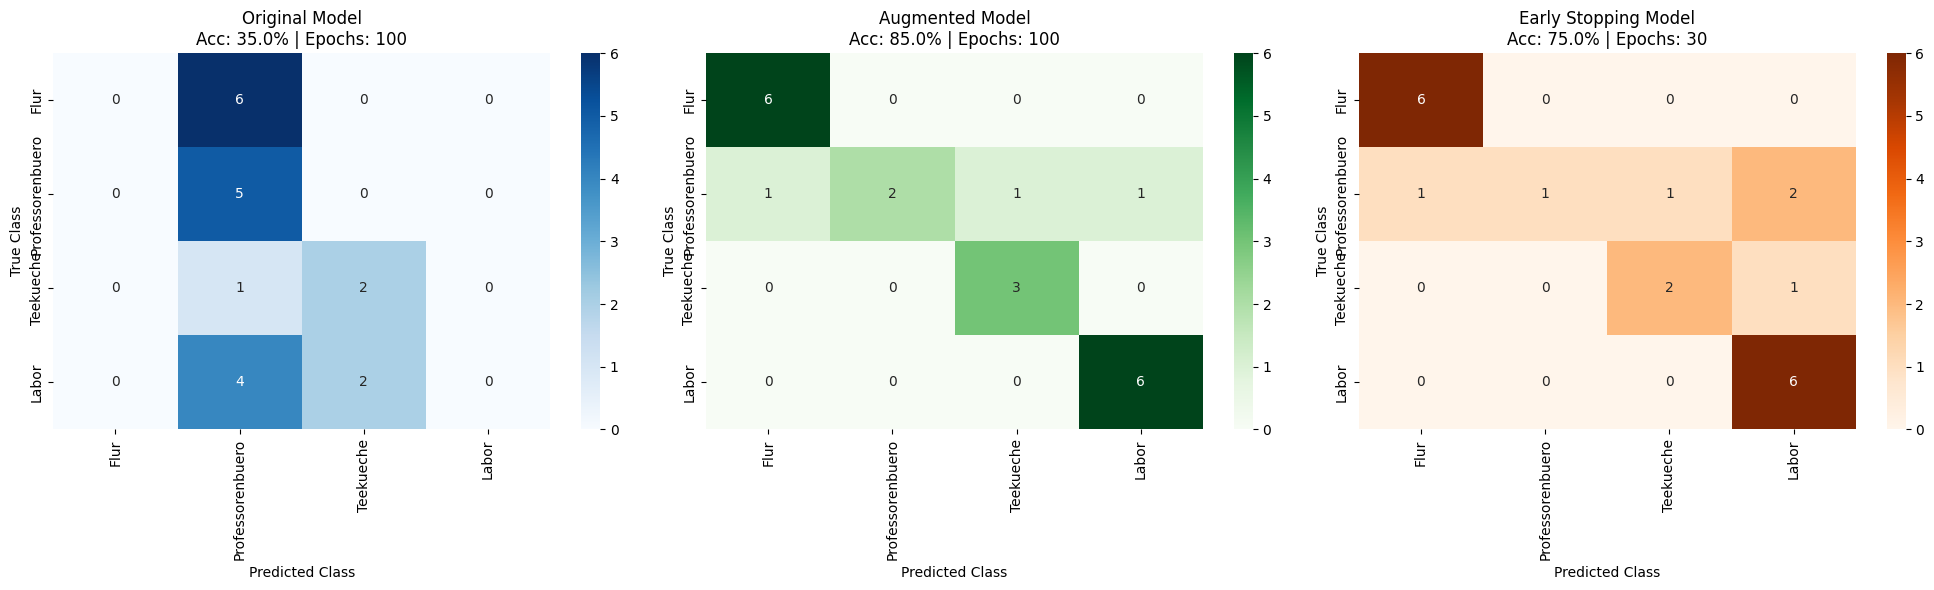


OVERFITTING ANALYSIS

Overfitting (Train-Val Gap):
   Original Model:     0.6625
   Augmented Model:    -0.1583
   Early Stopping:     -0.0083

Overfitting Reduction:
   Augmented vs Original:    +0.8208
   Early Stop vs Original:   +0.6708
   Early Stop vs Augmented:  -0.1500

--- Classification Report: Early Stopping Model ---
                  precision    recall  f1-score   support

            Flur     0.8571    1.0000    0.9231         6
Professorenbuero     1.0000    0.2000    0.3333         5
       Teekueche     0.6667    0.6667    0.6667         3
           Labor     0.6667    1.0000    0.8000         6

        accuracy                         0.7500        20
       macro avg     0.7976    0.7167    0.6808        20
    weighted avg     0.8071    0.7500    0.7003        20



In [20]:
import copy

class EarlyStopping:
    def __init__(self, patience=7, min_delta=0.001, restore_best_weights=True, verbose=True):
        """
        Early Stopping Callback for PyTorch Training

        Args:
            patience (int): Number of epochs with no improvement after which training will be stopped
            min_delta (float): Minimum change in the monitored quantity to qualify as an improvement
            restore_best_weights (bool): Whether to restore model weights from the epoch with the best value of the monitored quantity
            verbose (bool): Whether to print status messages
        """
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.verbose = verbose

        self.best_loss = float('inf')
        self.counter = 0
        self.best_weights = None
        self.early_stop = False
        self.best_epoch = 0

    def __call__(self, val_loss, model, epoch):
        """
        Check if early stopping should be triggered

        Args:
            val_loss (float): Current validation loss
            model: Model being trained
            epoch (int): Current epoch

        Returns:
            bool: True if training should be stopped
        """
        if val_loss < self.best_loss - self.min_delta:
            # Improvement found
            self.best_loss = val_loss
            self.counter = 0
            self.best_epoch = epoch

            # Save best weights
            if self.restore_best_weights:
                self.best_weights = copy.deepcopy(model.state_dict())

            if self.verbose:
                print(f"  → Validation loss improved to {val_loss:.4f} at epoch {epoch+1}")

        else:
            # No improvement
            self.counter += 1
            if self.verbose:
                print(f"  → No improvement for {self.counter}/{self.patience} epochs")

            if self.counter >= self.patience:
                self.early_stop = True
                if self.verbose:
                    print(f"  → Early stopping triggered! Best epoch was {self.best_epoch+1}")

        return self.early_stop

    def restore_weights(self, model):
        """Restore the best weights found during training"""
        if self.restore_best_weights and self.best_weights is not None:
            model.load_state_dict(self.best_weights)
            if self.verbose:
                print(f"  → Restored best weights from epoch {self.best_epoch+1} (val_loss: {self.best_loss:.4f})")

# Training with Early Stopping
print("--- Training with Early Stopping ---")

# Training settings for Early Stopping
max_epoch_early = 500  # Higher upper limit since early stopping will stop automatically
batch_size_early = 16
lr_early = 0.001
patience = 10  # Stop after this many epochs without improvement
min_delta = 0.001  # Minimum improvement

# Datasets for Early Stopping (use augmented transforms)
dataset_train_early = ROBDataset(training_path_list, y_train, transform=t_train_augmented)
dataloader_train_early = DataLoader(dataset_train_early, batch_size=batch_size_early, shuffle=True)

dataset_val_early = ROBDataset(validation_path_list, y_val, transform=t_val_standard)
dataloader_val_early = DataLoader(dataset_val_early, batch_size=batch_size_early, shuffle=False)

dataset_test_early = ROBDataset(test_path_list, y_test, transform=t_test_standard)
dataloader_test_early = DataLoader(dataset_test_early, batch_size=batch_size_early, shuffle=False)

print(f"\nDatasets created for early stopping:")
print(f"- Training batches: {len(dataloader_train_early)}")
print(f"- Validation batches: {len(dataloader_val_early)}")  
print(f"- Test batches: {len(dataloader_test_early)}")

# New net for early stopping
net_early = Net()
net_early.to(device)
optimizer_early = optim.Adam(net_early.parameters(), lr=lr_early)
criterion_early = nn.CrossEntropyLoss()

# Initialize Early Stopping Callback
early_stopping = EarlyStopping(patience=patience, min_delta=min_delta, 
                              restore_best_weights=True, verbose=False)

print(f"\nStarting training with Early Stopping...")
print(f"Max epochs: {max_epoch_early}, Patience: {patience}, Min delta: {min_delta}")

# Training loop with Early Stopping
train_loss_epoch_early = []
train_acc_epoch_early = []
val_loss_epoch_early = []
val_acc_epoch_early = []

for epoch in tqdm(range(max_epoch_early)):
    
    # Training
    net_early.train()
    train_loss_iter, train_acc_iter = run_iteration_aug(
        dataloader_train_early, net_early, optimizer_early, criterion_early, do_backprob=True
    )
    
    train_loss_epoch_early.append(train_loss_iter)
    train_acc_epoch_early.append(train_acc_iter)
    
    # Validation
    with torch.no_grad():
        net_early.eval()
        val_loss_iter, val_acc_iter = run_iteration_aug(
            dataloader_val_early, net_early, optimizer_early, criterion_early, do_backprob=False
        )
        
        val_loss_epoch_early.append(val_loss_iter)
        val_acc_epoch_early.append(val_acc_iter)
    
    # print(f"  Train Loss: {train_loss_iter:.4f}, Train Acc: {train_acc_iter:.4f}")
    # print(f"  Val Loss:   {val_loss_iter:.4f}, Val Acc:   {val_acc_iter:.4f}")
    
    # Early Stopping Check
    if early_stopping(val_loss_iter, net_early, epoch):
        print(f"\nEarly stopping triggered at epoch {epoch+1}")
        break

# Restore best weights
early_stopping.restore_weights(net_early)

print(f"\nTraining completed with early stopping!")
print(f"Total epochs trained: {len(train_loss_epoch_early)}")
print(f"Best validation loss: {early_stopping.best_loss:.4f}")
print(f"Best epoch: {early_stopping.best_epoch+1}")

# Test evaluation for Early Stopping model
print("\n--- Test Evaluation: Early Stopping Model ---")

net_early.eval()
all_predictions_early = []
all_true_labels_early = []
test_loss_total_early = 0.0

with torch.no_grad():
    for batch_x, batch_y in dataloader_test_early:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        
        y_predict = net_early(batch_x)
        loss = criterion_early(y_predict, batch_y)
        test_loss_total_early += loss.item()
        
        _, predicted = torch.max(torch.softmax(y_predict, dim=1), 1)
        all_predictions_early.extend(predicted.cpu().numpy())
        all_true_labels_early.extend(batch_y.cpu().numpy())

# Metrics for Early Stopping model
test_loss_avg_early = test_loss_total_early / len(dataloader_test_early)
accuracy_early = accuracy_score(all_true_labels_early, all_predictions_early)
f1_early = f1_score(all_true_labels_early, all_predictions_early, average='weighted', zero_division=0)
recall_early = recall_score(all_true_labels_early, all_predictions_early, average='weighted', zero_division=0)
precision_early = precision_score(all_true_labels_early, all_predictions_early, average='weighted', zero_division=0)

# Comparison plots: All three models
print("\n--- Performance Comparison: All Models ---")

plt.figure(figsize=(20, 12))

# Loss comparison - all models
plt.subplot(2, 4, 1)
plt.plot(train_loss_epoch, label="Original Train", linewidth=2)
plt.plot(val_loss_epoch, label="Original Val", linestyle="--", linewidth=2)
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.title('Original Model Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 4, 2)
plt.plot(train_loss_epoch_aug, label="Augmented Train", linewidth=2, color='green')
plt.plot(val_loss_epoch_aug, label="Augmented Val", linestyle="--", linewidth=2, color='green')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.title('Augmented Model Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 4, 3)
plt.plot(train_loss_epoch_early, label="Early Stop Train", linewidth=2, color='orange')
plt.plot(val_loss_epoch_early, label="Early Stop Val", linestyle="--", linewidth=2, color='orange')
plt.axvline(x=early_stopping.best_epoch, color='red', linestyle=':', alpha=0.7, label='Best Epoch')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.title('Early Stopping Model Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Direct comparison validation loss
plt.subplot(2, 4, 4)
plt.plot(val_loss_epoch, label="Original", linewidth=2)
plt.plot(val_loss_epoch_aug, label="Augmented", linewidth=2)
plt.plot(val_loss_epoch_early, label="Early Stopping", linewidth=2)
plt.ylabel('Validation Loss')
plt.xlabel('Epochs')
plt.title('Validation Loss Comparison')
plt.legend()
plt.grid(True, alpha=0.3)

# Accuracy comparison
plt.subplot(2, 4, 5)
plt.plot(train_acc_epoch, label="Original Train", linewidth=2)
plt.plot(val_acc_epoch, label="Original Val", linestyle="--", linewidth=2)
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.title('Original Model Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 4, 6)
plt.plot(train_acc_epoch_aug, label="Augmented Train", linewidth=2, color='green')
plt.plot(val_acc_epoch_aug, label="Augmented Val", linestyle="--", linewidth=2, color='green')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.title('Augmented Model Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 4, 7)
plt.plot(train_acc_epoch_early, label="Early Stop Train", linewidth=2, color='orange')
plt.plot(val_acc_epoch_early, label="Early Stop Val", linestyle="--", linewidth=2, color='orange')
plt.axvline(x=early_stopping.best_epoch, color='red', linestyle=':', alpha=0.7, label='Best Epoch')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.title('Early Stopping Model Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

# Direct comparison validation accuracy
plt.subplot(2, 4, 8)
plt.plot(val_acc_epoch, label="Original", linewidth=2)
plt.plot(val_acc_epoch_aug, label="Augmented", linewidth=2)
plt.plot(val_acc_epoch_early, label="Early Stopping", linewidth=2)
plt.ylabel('Validation Accuracy')
plt.xlabel('Epochs')
plt.title('Validation Accuracy Comparison')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("all_models_comparison.png", format="png", bbox_inches="tight", dpi=300)
plt.show()

# Final performance comparison
print("=" * 80)
print("FINAL PERFORMANCE COMPARISON")
print("=" * 80)

print("\n1. ORIGINAL MODEL:")
print(f"   Test Accuracy:  {accuracy:.4f}")
print(f"   Test F1-Score:  {f1:.4f}")
print(f"   Test Recall:    {recall:.4f}")
print(f"   Test Precision: {precision:.4f}")
print(f"   Epochs trained: {max_epoch}")
print(f"   Final Train-Val Gap: {train_acc_epoch[-1] - val_acc_epoch[-1]:.4f}")

print("\n2. AUGMENTED MODEL:")
print(f"   Test Accuracy:  {accuracy_aug:.4f}")
print(f"   Test F1-Score:  {f1_aug:.4f}")
print(f"   Test Recall:    {recall_aug:.4f}")
print(f"   Test Precision: {precision_aug:.4f}")
print(f"   Epochs trained: {max_epoch_aug}")
print(f"   Final Train-Val Gap: {train_acc_epoch_aug[-1] - val_acc_epoch_aug[-1]:.4f}")

print("\n3. EARLY STOPPING MODEL:")
print(f"   Test Accuracy:  {accuracy_early:.4f}")
print(f"   Test F1-Score:  {f1_early:.4f}")
print(f"   Test Recall:    {recall_early:.4f}")
print(f"   Test Precision: {precision_early:.4f}")
print(f"   Epochs trained: {len(train_loss_epoch_early)}")
print(f"   Best epoch:     {early_stopping.best_epoch+1}")
print(f"   Final Train-Val Gap: {train_acc_epoch_early[-1] - val_acc_epoch_early[-1]:.4f}")

# Efficiency analysis
print("\n" + "=" * 80)
print("EFFICIENCY ANALYSIS")
print("=" * 80)

epochs_saved_vs_orig = max_epoch - len(train_loss_epoch_early)
epochs_saved_vs_aug = max_epoch_aug - len(train_loss_epoch_early)

print(f"\nEarly Stopping Efficiency:")
print(f"   Epochs saved vs Original:  {epochs_saved_vs_orig:+d} ({epochs_saved_vs_orig/max_epoch*100:.1f}% time savings)")
print(f"   Epochs saved vs Augmented: {epochs_saved_vs_aug:+d} ({epochs_saved_vs_aug/max_epoch_aug*100:.1f}% time savings)")

# Improvement analysis
print("\n" + "=" * 80)
print("IMPROVEMENT ANALYSIS")
print("=" * 80)

print("\nEarly Stopping vs Original:")
print(f"   Accuracy:  {accuracy_early - accuracy:+.4f}")
print(f"   F1-Score:  {f1_early - f1:+.4f}")
print(f"   Efficiency: {epochs_saved_vs_orig:+d} fewer epochs")

print("\nEarly Stopping vs Augmented:")
print(f"   Accuracy:  {accuracy_early - accuracy_aug:+.4f}")
print(f"   F1-Score:  {f1_early - f1_aug:+.4f}")
print(f"   Efficiency: {epochs_saved_vs_aug:+d} fewer epochs")

# Confusion matrix for all models
cm_early = confusion_matrix(all_true_labels_early, all_predictions_early)

plt.figure(figsize=(20, 6))

# Original confusion matrix
plt.subplot(1, 3, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_directories, 
            yticklabels=class_directories)
plt.title(f'Original Model\nAcc: {accuracy:.1%} | Epochs: {max_epoch}')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')

# Augmented confusion matrix
plt.subplot(1, 3, 2)
sns.heatmap(cm_aug, annot=True, fmt='d', cmap='Greens', 
            xticklabels=class_directories, 
            yticklabels=class_directories)
plt.title(f'Augmented Model\nAcc: {accuracy_aug:.1%} | Epochs: {max_epoch_aug}')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')

# Early Stopping confusion matrix
plt.subplot(1, 3, 3)
sns.heatmap(cm_early, annot=True, fmt='d', cmap='Oranges', 
            xticklabels=class_directories, 
            yticklabels=class_directories)
plt.title(f'Early Stopping Model\nAcc: {accuracy_early:.1%} | Epochs: {len(train_loss_epoch_early)}')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')

plt.tight_layout()
plt.savefig("final_confusion_matrices.png", format="png", bbox_inches="tight", dpi=300)
plt.show()

# Overfitting analysis
print("\n" + "=" * 80)
print("OVERFITTING ANALYSIS")
print("=" * 80)

overfitting_orig = train_acc_epoch[-1] - val_acc_epoch[-1]
overfitting_aug = train_acc_epoch_aug[-1] - val_acc_epoch_aug[-1]
overfitting_early = train_acc_epoch_early[-1] - val_acc_epoch_early[-1]

print(f"\nOverfitting (Train-Val Gap):")
print(f"   Original Model:     {overfitting_orig:.4f}")
print(f"   Augmented Model:    {overfitting_aug:.4f}")
print(f"   Early Stopping:     {overfitting_early:.4f}")

print(f"\nOverfitting Reduction:")
print(f"   Augmented vs Original:    {overfitting_orig - overfitting_aug:+.4f}")
print(f"   Early Stop vs Original:   {overfitting_orig - overfitting_early:+.4f}")
print(f"   Early Stop vs Augmented:  {overfitting_aug - overfitting_early:+.4f}")

# Classification report for Early Stopping
print("\n--- Classification Report: Early Stopping Model ---")
print(classification_report(all_true_labels_early, all_predictions_early, 
                          target_names=class_directories, digits=4))